<a href="https://colab.research.google.com/github/peterjsadowski/keras_tutorial/blob/master/1_keras_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Quick Start: MNIST in Keras


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.regularizers import l2

## Load data set.

In [5]:
# Load data.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print("Original X shape", X_train.shape)
print("Original Y shape", Y_train.shape)

# Reshape data.
X_train = X_train.reshape(60000, 784)
X_test  = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255 # Original data is uint8 (0-255). Scale it to range [0,1].
X_test  /= 255
print("Training X matrix shape", X_train.shape)
print("Testing X matrix shape", X_test.shape)

# Represent the targets as one-hot vectors: e.g. 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0].
nb_classes = 10
Y_train = keras.utils.to_categorical(Y_train, nb_classes)
Y_test  = keras.utils.to_categorical(Y_test, nb_classes)
print("Training Y matrix shape", Y_train.shape)
print("Testing Y matrix shape", Y_test.shape)

Original X shape (60000, 28, 28)
Original Y shape (60000,)
Training X matrix shape (60000, 784)
Testing X matrix shape (10000, 784)
Training Y matrix shape (60000, 10)
Testing Y matrix shape (10000, 10)


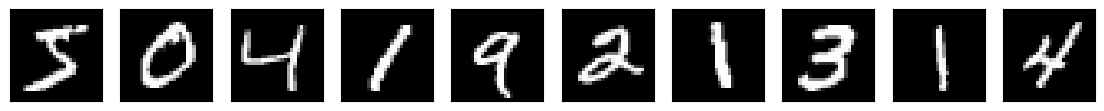

In [6]:
# Plot examples of the data.
plt.figure(1, figsize=(14,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

# Neural Network in Keras


In [7]:
# Simple fully-connected neural network with 2 hidden layers.
model = Sequential()
# Use input_shape=(28,28) for unflattened data.
model.add(Dense(256, activation='relu', input_shape=(784,), kernel_regularizer=l2(0.001)))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax')) # Use softmax layer for multi-class problems.

## Compile the Keras model.
Compiling the model **builds** each layer. Keras examines the computation graph and automatically determines the size of the weight tensors at each layer. These weights are then initialized.

The **loss function** is the objective function being optimized, and the *categorical crossentropy* is the appropriate loss function for the *softmax* output. For *logistic* outputs use *binomial crossentropy*, and for linear outputs use *mean_squared_error*. Some notes on the math behind this can be found here: https://peterjsadowski.github.io/assets/pdf/notes_backpropagation.pdf.

The **accuracy** is just a metric that we keep track of during training. Keras also allows you to define your own metrics.

The **optimizer** is the algorithm used to update the weights. Typical choices include *sgd*, *rmsprop*, or *adam*. ADAM is a good choice for quick results, but standard SGD is easier to debug. In this tutorial, we use the default hyperparameters for the optimization (e.g. the initial *learning rate*), but these generally need to be tuned for each problem.

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model.
Weights are updated one mini-batch at a time. A running average of the training loss is computed in real time, which is useful for identifying problems (e.g. the loss might explode or get stuck right). The validation loss is evaluated at the end of each epoch (without dropout).

In [9]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=10, verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/10
469/469 [==============================] - 5s 4ms/step - loss: 0.4297 - accuracy: 0.9243 - val_loss: 0.2374 - val_accuracy: 0.9613
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2023 - accuracy: 0.9661 - val_loss: 0.1732 - val_accuracy: 0.9711
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1551 - accuracy: 0.9733 - val_loss: 0.1445 - val_accuracy: 0.9753
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1385 - accuracy: 0.9764 - val_loss: 0.1420 - val_accuracy: 0.9751
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1238 - accuracy: 0.9799 - val_loss: 0.1509 - val_accuracy: 0.9703
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1168 - accuracy: 0.9801 - val_loss: 0.1410 - val_accuracy: 0.9719
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1112 - accuracy: 0.9823 - val_loss: 0.1694 - val_accuracy: 0.9657
Epoch 

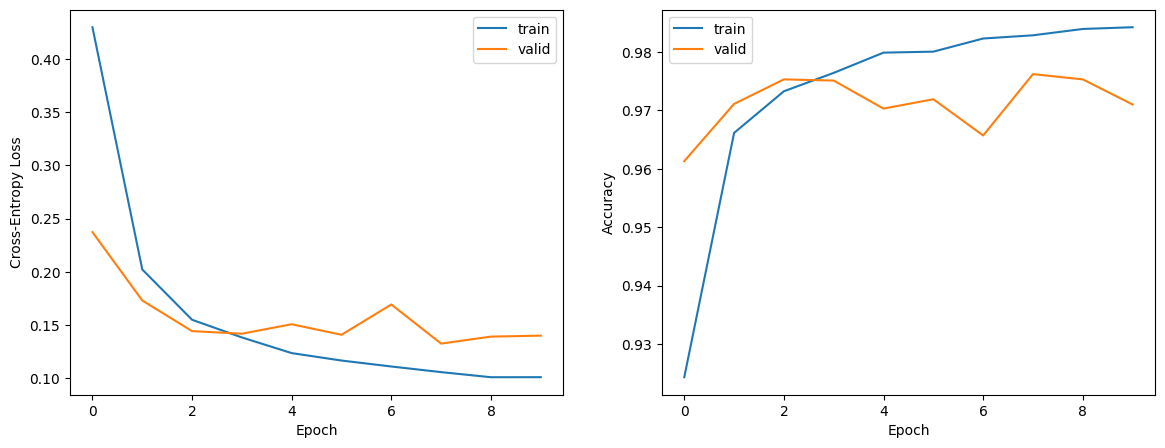

In [10]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Evaluate performance

In [11]:
# Note: when calling evaluate, dropout is automatically turned off.
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.2f' % score[1])

Test cross-entropy loss: 0.14021
Test accuracy: 0.97


### Inspecting the output
This is always a good sanity check. Here we show some correctly-labeled and incorrectly-labeled examples.

313/313 [==============================] - 0s 1ms/step


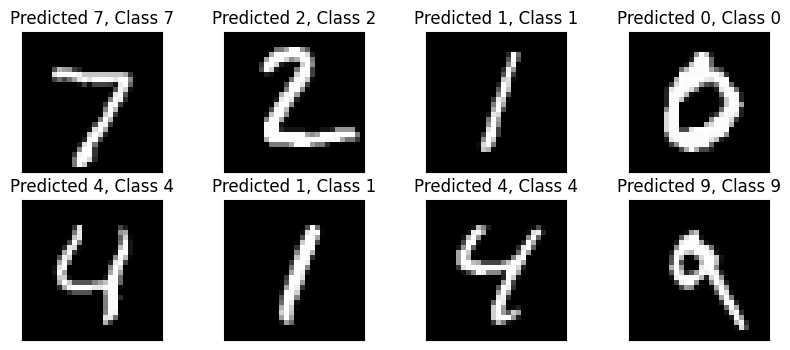

In [14]:
predicted_classes = model.predict(X_test).argmax(axis=-1)
correct_indices   = np.nonzero(predicted_classes == Y_test.argmax(axis=-1))[0]
incorrect_indices = np.nonzero(predicted_classes != Y_test.argmax(axis=-1))[0]

plt.figure(1, figsize=(10,4))
for i, correct in enumerate(correct_indices[:8]):
    plt.subplot(2,4,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], Y_test[correct].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])

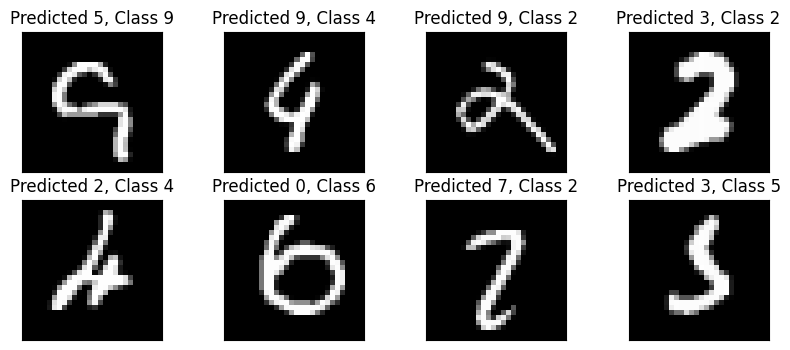

In [15]:
# Plot some incorrectly labeled examples.
plt.figure(2, figsize=(10,4))
for i, incorrect in enumerate(incorrect_indices[:8]):
    plt.subplot(2,4,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], Y_test[incorrect].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])

## Examine the learned features.
We can interpret the features in the first layer by visualizing the weights.

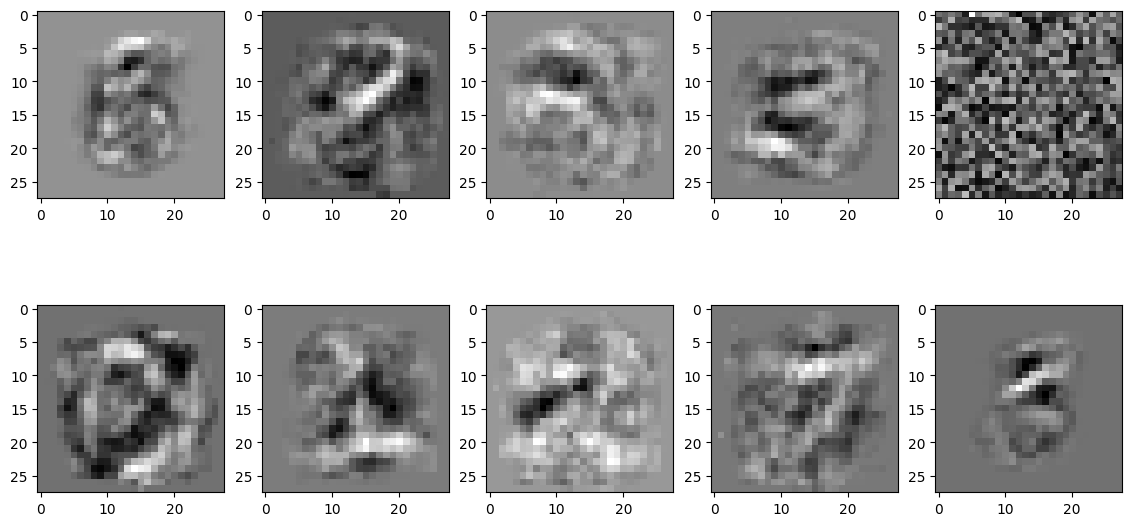

In [16]:
# We can get an
W = model.layers[0].get_weights()[0] # Weight matrix W is a shared variable object, not a numpy array.
plt.figure(1, figsize=(14,7))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(W[:,i].reshape(28,28), cmap='gray', interpolation='none')


# See also:
Keras documentation:
https://keras.io/

More examples:
https://github.com/fchollet/keras/blob/master/examples/

